In [ ]:
import pickle
import pandas as pd
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image, ImageSequence
from pathlib import Path
import os

import torch
from torchvision import transforms, models, datasets
from torchvision.transforms import ToTensor
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/data.zip -d my_data

In [ ]:
!ls my_data/data

178  182  186  190  194  198  203  348	353  357  362
179  183  187  191  195  199  204  349	354  358  364
180  184  188  192  196  200  345  350	355  360  367
181  185  189  193  197  201  347  351	356  361  classes.xlsx


In [ ]:
my_labels = pd.read_excel('my_data/data/classes.xlsx')

In [ ]:
my_labels

,№,"Узел ЩЖ, TIRADS"
0,178,4
1,179,5
2,180,3
3,181,5
4,182,3
5,183,5
6,184,5
7,185,5
8,186,5
9,187,5


In [ ]:
labels = dict(zip(my_labels['№'], my_labels['Узел ЩЖ, TIRADS']))

In [ ]:
for k in labels:
    if labels[k] == 5:
        labels[k] = 1
    else:
        labels[k] = 0

In [ ]:
del labels[202]
del labels[346]
del labels[363]
del labels[365]
del labels[366]

In [ ]:
labels

{178: 0,
 179: 1,
 180: 0,
 181: 1,
 182: 0,
 183: 1,
 184: 1,
 185: 1,
 186: 1,
 187: 1,
 188: 0,
 189: 0,
 190: 0,
 191: 1,
 192: 0,
 193: 0,
 194: 1,
 195: 1,
 196: 0,
 197: 1,
 198: 0,
 199: 0,
 200: 0,
 201: 0,
 203: 1,
 204: 1,
 345: 1,
 347: 0,
 348: 0,
 349: 0,
 350: 0,
 351: 0,
 353: 0,
 354: 0,
 355: 1,
 356: 1,
 357: 0,
 358: 1,
 360: 0,
 361: 1,
 362: 0,
 364: 1,
 367: 1}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
data_dir = Path('/content/my_data/data')

In [ ]:
def read_data(data_dir):
    images, all_labels = [], []
    for k in labels.keys():
        label = labels[k]
        folder_name = os.path.join(data_dir, str(k))
        for file in os.listdir(folder_name):
            name = os.path.basename(file)
            if name.endswith('long.tif') or name.endswith('cross.tif'):
                new_path = os.path.join(folder_name, name)
                image = Image.open(new_path)
                for i, page in enumerate(ImageSequence.Iterator(image)):
                    images.append(page)
                    all_labels.append(label)
    return images, all_labels

In [ ]:
all_data = read_data(data_dir)

In [ ]:
len(all_data[0])

7344

In [ ]:
class TIRADSDataset(Dataset):
    def __init__(self, files, labels):
        super().__init__()
        self.files = files
        self.labels = labels
        self.len_ = len(self.files)


    def __len__(self):
        return self.len_


    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize((0.5), (0.5))
        ])

        x = self.files[index]
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        label = self.labels[index]
        number = self.numbers[index]
        return x, torch.tensor(label)

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [ ]:
from sklearn.model_selection import train_test_split
train_files, test_files, train_labels, test_labels = train_test_split(all_data[0], all_data[1], test_size=0.25, stratify=all_data[1])

In [ ]:
train_dataset = TIRADSDataset(train_files, train_labels)
test_dataset = TIRADSDataset(test_files, test_labels)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
def train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    val_acc_f_best = 0
    best_acc = 0
    for epoch in tqdm_notebook(range(epochs)):
        train_loss_ep = []
        preds = []
        target = []

        model.train()
        for batch, labels in train_dataloader:
            batch = batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            preds.append(output.argmax(dim=1))
            train_loss_ep.append(loss.item())
            target.append(labels)

        preds = torch.cat(preds)
        target = torch.cat(target)
        acc = (preds == target).float().mean().item()

        train_acc.append(acc)
        train_loss.append(sum(train_loss_ep) / len(train_loss_ep))
        print(f'Train loss: {sum(train_loss_ep) / len(train_loss_ep)}. Train accuracy: {acc}')

        test_loss_ep = []
        test_preds = []
        test_target = []

        model.eval()
        with torch.no_grad():
            for batch, labels in test_dataloader:
                batch = batch.to(device)
                labels = labels.to(device)

                output = model(batch)
                loss = criterion(output, labels)

                test_preds.append(output.argmax(dim=1))
                test_loss_ep.append(loss.item())
                test_target.append(labels)

            test_preds = torch.cat(test_preds)
            test_target = torch.cat(test_target)
            acc = (test_preds == test_target).float().mean().item()
            val_acc_f_best = acc

            test_acc.append(acc)
            test_loss.append(sum(test_loss_ep) / len(test_loss_ep))
            print(f'Test loss: {sum(test_loss_ep) / len(test_loss_ep)}. Test accuracy: {acc}')

        if val_acc_f_best > best_acc:
            best_acc = val_acc_f_best
            best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)
    return model, train_loss, test_loss, train_acc, test_acc

In [ ]:
model_resnet18 = models.resnet18(pretrained=True).to(device)
print(model_resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
numb = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(numb, 2)
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_resnet18 = model_resnet18.to(device)

In [ ]:
for name, params in model_resnet18.named_parameters():
    print(name, 'requires_grad:', params.requires_grad)

conv1.weight requires_grad: True
bn1.weight requires_grad: True
bn1.bias requires_grad: True
layer1.0.conv1.weight requires_grad: True
layer1.0.bn1.weight requires_grad: True
layer1.0.bn1.bias requires_grad: True
layer1.0.conv2.weight requires_grad: True
layer1.0.bn2.weight requires_grad: True
layer1.0.bn2.bias requires_grad: True
layer1.1.conv1.weight requires_grad: True
layer1.1.bn1.weight requires_grad: True
layer1.1.bn1.bias requires_grad: True
layer1.1.conv2.weight requires_grad: True
layer1.1.bn2.weight requires_grad: True
layer1.1.bn2.bias requires_grad: True
layer2.0.conv1.weight requires_grad: True
layer2.0.bn1.weight requires_grad: True
layer2.0.bn1.bias requires_grad: True
layer2.0.conv2.weight requires_grad: True
layer2.0.bn2.weight requires_grad: True
layer2.0.bn2.bias requires_grad: True
layer2.0.downsample.0.weight requires_grad: True
layer2.0.downsample.1.weight requires_grad: True
layer2.0.downsample.1.bias requires_grad: True
layer2.1.conv1.weight requires_grad: True


In [ ]:
for name, params in model_resnet18.named_parameters():
    if name.startswith('layer4.1.') or name.startswith('fc.'):
        params.requires_grad = True
    else:
        params.requires_grad = False
    print(name, 'requires_grad:', params.requires_grad)

conv1.weight requires_grad: False
bn1.weight requires_grad: False
bn1.bias requires_grad: False
layer1.0.conv1.weight requires_grad: False
layer1.0.bn1.weight requires_grad: False
layer1.0.bn1.bias requires_grad: False
layer1.0.conv2.weight requires_grad: False
layer1.0.bn2.weight requires_grad: False
layer1.0.bn2.bias requires_grad: False
layer1.1.conv1.weight requires_grad: False
layer1.1.bn1.weight requires_grad: False
layer1.1.bn1.bias requires_grad: False
layer1.1.conv2.weight requires_grad: False
layer1.1.bn2.weight requires_grad: False
layer1.1.bn2.bias requires_grad: False
layer2.0.conv1.weight requires_grad: False
layer2.0.bn1.weight requires_grad: False
layer2.0.bn1.bias requires_grad: False
layer2.0.conv2.weight requires_grad: False
layer2.0.bn2.weight requires_grad: False
layer2.0.bn2.bias requires_grad: False
layer2.0.downsample.0.weight requires_grad: False
layer2.0.downsample.1.weight requires_grad: False
layer2.0.downsample.1.bias requires_grad: False
layer2.1.conv1.wei

In [ ]:
opt = torch.optim.Adam((list(model_resnet18.parameters()))[-8:], lr=1e-3)
criterion = loss = nn.CrossEntropyLoss()

In [ ]:
best_model, train_loss, test_loss, train_acc, test_acc = train(model_resnet18, train_loader, test_loader, opt, criterion, epochs=20)

<ipython-input-23-0d733ab47059>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.08317894141041177. Train accuracy: 0.9689542651176453
Test loss: 0.0270716960964384. Test accuracy: 0.9831154346466064
Train loss: 0.020270481284066024. Train accuracy: 0.9925562739372253
Test loss: 4.685550440191709e-05. Test accuracy: 1.0
Train loss: 0.0010237353007313146. Train accuracy: 0.9998184442520142
Test loss: 2.7009876396772124e-06. Test accuracy: 1.0
Train loss: 0.00018260252170108104. Train accuracy: 1.0
Test loss: 1.1590895536281333e-06. Test accuracy: 1.0
Train loss: 0.0009579356602564712. Train accuracy: 0.9998184442520142
Test loss: 1.3474805431611536e-06. Test accuracy: 1.0
Train loss: 0.029579370943028534. Train accuracy: 0.9907407164573669
Test loss: 0.00023475764280276408. Test accuracy: 1.0
Train loss: 0.0179839948342312. Train accuracy: 0.9938271641731262
Test loss: 3.8844117036363886e-05. Test accuracy: 1.0
Train loss: 0.0019544470033797125. Train accuracy: 0.9994553327560425
Test loss: 2.266056868935691e-06. Test accuracy: 1.0
Train loss: 0.000213

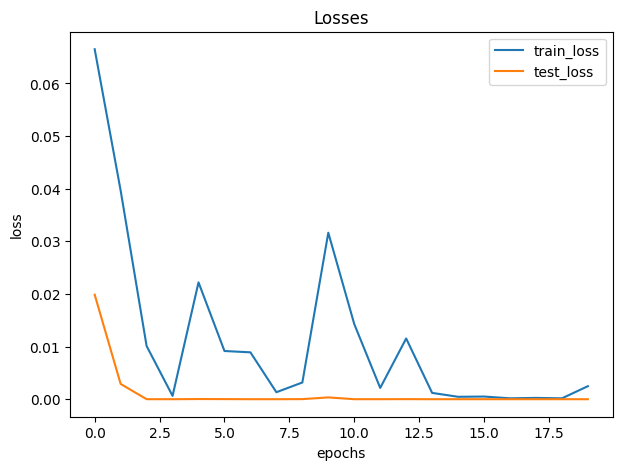

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.title('Losses')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Функция потерь на тренировочных данны демонстрирует повторяющееся, ступенчатое поведение. Возможно, входные данные, видимые моделью, сами демонстрируют повторяющееся поведение. Это связано с тем, что в тестовом и тренировочном датасетах много сильно схожих изображений из одних кинопетель, соотвественно, для модели данные практически повторяют друг друга.

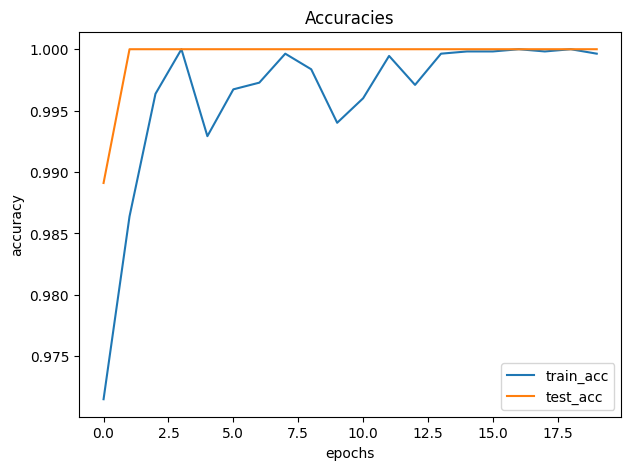

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.title('Accuracies')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
print(f'Epoch of maximum accuracy on training data: {train_acc.index(max(train_acc)) + 1}')
print(f'Epoch of minimum loss on training data: {train_loss.index(min(train_loss)) + 1}')

Epoch of maximum accuracy on training data: 4
Epoch of minimum loss on training data: 19


In [ ]:
print(f'Epoch of maximum accuracy on testing data: {test_acc.index(max(test_acc)) + 1}')
print(f'Epoch of minimum loss on testing data: {test_loss.index(min(test_loss)) + 1}')

Epoch of maximum accuracy on testing data: 2
Epoch of minimum loss on testing data: 19


# Testing

In [ ]:
!unzip -q /content/gdrive/MyDrive/new_data.zip -d test_data

In [ ]:
!ls test_data/new_data

101_cross.tif  140_long.tif  67_cross.tif  77_cross.tif  88_cross.tif
101_long.tif   143_long.tif  71_cross.tif  80_cross.tif  90_long.tif
103_long.tif   37_long.tif   72_long.tif   80_long.tif	 94_cross.tif
114_long.tif   61_cross.tif  73_cross.tif  87_cross.tif  94_long.tif


In [ ]:
test_data_dir = Path('/content/test_data/new_data')

In [ ]:
def read_test_data(data_dir):
    images, number = [], []
    for file in os.listdir(data_dir):
        name = os.path.basename(file)
        index = name.index('_')
        numb = str(name[:index])
        new_path = os.path.join(data_dir, name)
        image = Image.open(new_path)
        for i, page in enumerate(ImageSequence.Iterator(image)):
            images.append(page)
            number.append(numb)
    return images, number

In [ ]:
test_files, test_number = read_test_data(test_data_dir)

In [ ]:
len(test_files)

1365

In [ ]:
class TIRADSDatasetTest(Dataset):
    def __init__(self, files, numbers):
        super().__init__()
        self.files = files
        self.numbers = numbers
        self.len_ = len(self.files)


    def __len__(self):
        return self.len_


    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize((0.5), (0.5))
        ])

        x = self.files[index]
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        number = self.numbers[index]
        return x, number

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [ ]:
test_dataset = TIRADSDatasetTest(test_files, test_labels, test_number)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
def predict_test(model, loader, device=device):
    model.eval()
    test_preds = []
    ans = {}
    count_numb = {}
    numbers = []
    with torch.no_grad():
          for batch, labels, number in loader:
              batch = batch.to(device)
              output = model(batch)
              test_preds.append(output.argmax(dim=1))
              number = list(number)
              numbers.extend(number)
          test_preds = torch.cat(test_preds)
          for i in range(len(numbers)):
              if numbers[i] in ans:
                  ans[numbers[i]] += test_preds[i]
                  count_numb[numbers[i]] += 1
              else:
                  ans[numbers[i]] = test_preds[i]
                  count_numb[numbers[i]] = 1
    return test_preds, ans, count_numb

In [ ]:
test_pred_label, ans, count_numb = predict_test(best_model, test_loader)

In [ ]:
preds = {}
for key in ans:
    preds[key] = ans[key] / count_numb[key]

In [ ]:
preds

{'71': tensor(0., device='cuda:0'),
 '67': tensor(1., device='cuda:0'),
 '114': tensor(0.5195, device='cuda:0'),
 '80': tensor(1., device='cuda:0'),
 '103': tensor(0.5143, device='cuda:0'),
 '143': tensor(0.5000, device='cuda:0'),
 '101': tensor(0.3182, device='cuda:0'),
 '88': tensor(1., device='cuda:0'),
 '37': tensor(1., device='cuda:0'),
 '77': tensor(0.4455, device='cuda:0'),
 '140': tensor(0.4524, device='cuda:0'),
 '61': tensor(0., device='cuda:0'),
 '87': tensor(0., device='cuda:0'),
 '90': tensor(1.0000, device='cuda:0'),
 '72': tensor(0.4464, device='cuda:0'),
 '94': tensor(0.7639, device='cuda:0'),
 '73': tensor(1., device='cuda:0')}

In [ ]:
last_preds = {}
for key in preds:
    last_preds[key] = round(preds[key].item())

In [ ]:
last_preds

{'71': 0,
 '67': 1,
 '114': 1,
 '80': 1,
 '103': 1,
 '143': 0,
 '101': 0,
 '88': 1,
 '37': 1,
 '77': 0,
 '140': 0,
 '61': 0,
 '87': 0,
 '90': 1,
 '72': 0,
 '94': 1,
 '73': 1}

In [ ]:
data = {'id': last_preds.keys(),
        'label': last_preds.values()}
test_labels_prediction = pd.DataFrame.from_dict(data)
test_labels_prediction

,id,label
0,71,0
1,67,1
2,114,1
3,80,1
4,103,1
5,143,0
6,101,0
7,88,1
8,37,1
9,77,0


In [ ]:
test_labels_prediction.to_csv('./lab_task_submission.csv', index=False)